# Atmosphere Plotter Notebook: Version 2 - Cloudy vs LessCloudy

This notebook read the spectral datacubes generated by `PolarVortice/AtmosphereGenerator.py`.

The datacubes are located at `PolarVortice/output/`. In this script, I configured it to read only `production` datacubes.

1. **Step 1**: Read Spectral Monitoring Data 
2. **Step 2**: Generate Synthetic Spectra Cube with Sonora


#### Step 0: Initialization

In [1]:
import astropy.constants as c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
import h5py
from astropy.convolution import convolve, Box1DKernel
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import scipy.interpolate

matplotlib.rcParams.update({'font.size': 12})

In [2]:
### ========= function to print levels of nested dicts =================
def print_nested_dict(d, indent=0):
    for key, value in d.items():
        print("  " * indent + str(key) + ":")
        if isinstance(value, dict):
            print_nested_dict(value, indent + 1)
        else:
            print("  " * (indent + 1) + str(value))

### ========= lamda function to create nested_dict ======================
nested_dict = lambda: defaultdict(nested_dict)

### ========= function to bring array value to one ======================
def bring_to_one(array):
    shift = (array.max() + array.min())/2
    return 1 + array - shift

### ========= itertools to generated random marker =====================
import itertools
markerRandomList = itertools.cycle((',', '+', '.', 'o', '*'))
linestyleRandomList = itertools.cycle(('--', '-', '-.'))
### Usage
# for n in y:
#     plt.plot(x,n, marker = next(marker), linestyle='')

### =========  Function to do log-log interpolation =====================
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

### =========  Path to save plot figures ================================
plotPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/AtmopsherePlotterOutputPlots/'

## Step 1: Read Spectral Monitoring Data Cube

#### Initialization

- Choose class of models to read.
- model_class, model_id, inclination, starting_time, end_time, frame_numbers
- data structure:

dict:static|dynamic|nopolar|
=> dict:inclination_value:'string' 
=> dict:time_value:'string' 
=> numpy:gray_array:2d_image

#### 1A) [read, print] Read files into 1 dictionary contain 3 classes: Polar_static, Polar_dynamic, NoPolar

In [3]:
directory = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/"
production0_list = []
other_list = []

productionKey = 'production0'
# modelclassKey = ['polarStatic', 'polarDynamic', 'noPolar']
# modelclassKey = ['polarStatic', 'noPolar']

print('============================================================')
print('Production key: "%s"'%productionKey)
print('\nThe production datacubes includes:')
for foldername in os.listdir(directory):
    if productionKey in foldername and 'polarDynamic' not in foldername:
        print(foldername)
        production0_list.append(directory+foldername+'/')
    else:
        other_list.append(directory+foldername+'/')
print('============================================================')
print('\n')
# ================================================================
# Function to categorize file names
# ================================================================
def categorize_filenames(directory_list):
    # create empty, pre-nested dicts
    datacubes = nested_dict()
    metadatas = nested_dict()
    
    for directory in directory_list:
        # Iterate over files in the directory
        for filename in os.listdir(directory):
            # print(filename)
            # Check if the file is a H5 file
            if filename.endswith(".h5"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = str(parts[1])
                class_name = str(parts[0])
                incli_value = str(parts[2])
                t1t2FrameNo_value = parts[3] + "-" + parts[4] + "-" + parts[5]

                # Load numpy array from H5 file
                with h5py.File(os.path.join(directory, filename), 'r') as f:
                    data = f['dataset'][:]
                    datacubes[model_id][class_name][incli_value][t1t2FrameNo_value] = data
            
            # Check if the file is a pickle file
            if filename.endswith(".pkl"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = parts[2]
                class_name = parts[1]
                incli_value = parts[3]
                t1t2FrameNo_value = parts[4] + "-" + parts[5] + "-" + parts[6]

                # Load metadata from pickle file
                with open(os.path.join(directory, filename), 'rb') as f:
                    data = pickle.load(f)
                    metadatas[model_id][class_name][incli_value][t1t2FrameNo_value] = data
                    
    return datacubes, metadatas

Production key: "production0"

The production datacubes includes:
dataCube[production0][noPolar][i][0][60][60]
dataCube[production0][polarStatic][i][0][30][30]
dataCube[production0][polarStatic][i][0][60][60]
dataCube[production0][noPolar][i][0][30][30]




In [5]:
# read the production datacube
datacubes, metadatas = categorize_filenames(production0_list)

# ============================================================
# Print bookkeeping information
# ============================================================
modelclasses = []
modelclasses = list(datacubes['production0'].keys())

print('============================================================')
print('--> Datacubes contains these model classes:', modelclasses)

for model in modelclasses:
    incli = list(datacubes['production0'][model].keys())
    incli = sorted([int(x) for x in incli]) 
    incli = [str(x) for x in incli]
    
    photo_config = list(datacubes['production0'][model][incli[0]].keys())
    
    # =======================================================
    # Choose which photometry configuration to use: 
    # Currently photo_config
    # =======================================================
    
    for config in photo_config:
        if config == '0-60-60':
        # if config == '0-30-30':

            photo_config0 = config
            no_frame = datacubes['production0'][model][incli[0]][photo_config0].shape[0]
            print('\n--> Using the photometry config: [%s] (t0-t1-no_frame)'%photo_config0)
            print('\n--> [%s] contains these inclination'%model, sorted(incli))
            print('for [t0]-[t1]-[FrameNumber]:', photo_config0)

            metakeys = list(metadatas['production0'][model][incli[0]][photo_config0].keys())
            c
            t0, t1 = int(photo_config0.split('-')[0]), int(photo_config0.split('-')[1])

            time_array = np.linspace(t0, t1-1, no_frame) 

            print('Total no. of frames:', no_frame, ', cadence: %.1f min'%((t1-t0)/no_frame*60))

print('\n--> The metadata contains these attributes: \n', metakeys)
print('============================================================')

--> Datacubes contains these model classes: ['noPolar', 'polarStatic']

--> Using the photometry config: [0-60-60] (t0-t1-no_frame)

--> [noPolar] contains these inclination ['-10', '-20', '-30', '-40', '-50', '-60', '-70', '-80', '-90', '0']
for [t0]-[t1]-[FrameNumber]: 0-60-60
Total no. of frames: 60 , cadence: 60.0 min

--> Using the photometry config: [0-60-60] (t0-t1-no_frame)

--> [polarStatic] contains these inclination ['-10', '-20', '-30', '-40', '-50', '-60', '-70', '-80', '-90', '0']
for [t0]-[t1]-[FrameNumber]: 0-60-60
Total no. of frames: 60 , cadence: 60.0 min

--> The metadata contains these attributes: 
 ['modu_config', 'modelname', 'inclin', 'Fband', 'Fambient', 'Pband', 'Ppol', 'config_columns', 'config', 'specmap', 'speckey', 'cond_is_amb', 'cond_is_band', 'cond_is_pol']


#### 1B) [plot] Photometry and specmaps 

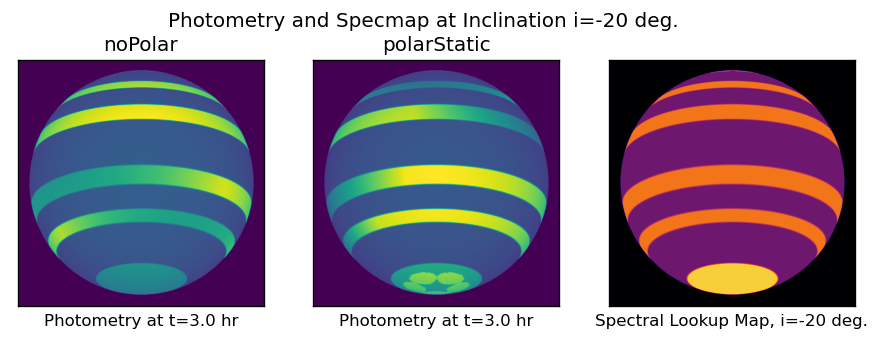

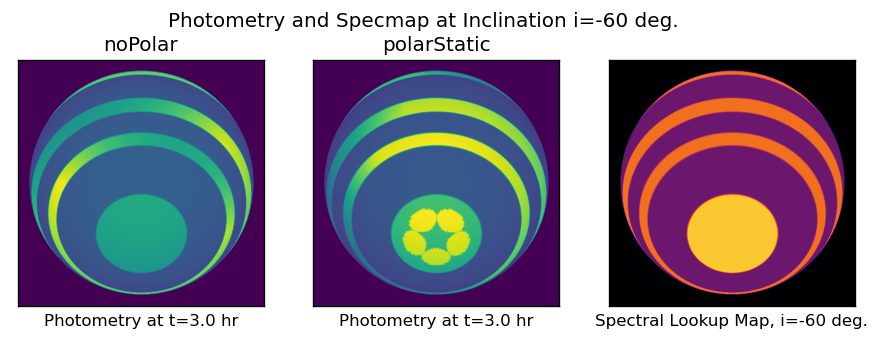

In [6]:
# ============================================================
# [[Plot]]
# Plot the first photometry-frame, spectra-map for one inclin
# of each model class
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes['production0'][model][incli[0]][photo_config0].shape[0]

%matplotlib inline
plt.close('all')
for iang in ['-20', '-60']:
    fig, axs = plt.subplots(1, 3, dpi=120, figsize=(9,3))
    cadence = (t1-t0)/no_frame
    fig.suptitle('Photometry and Specmap at Inclination i=%s deg.'%iang)
    for i, model in enumerate(modelclasses):
        photo_config0 = photo_config[0]
        if model == 'polarStatic': timepoint = 3
        else: timepoint = 2
        gray = datacubes['production0'][model][iang][photo_config0][timepoint][0]
        axs[i].imshow(gray)
        axs[i].set_title(model)
        axs[i].set_xticks([]), axs[i].set_yticks([])
        axs[i].set_xticks([]), axs[i].set_yticks([])

    specmap = metadatas['production0'][model][iang][photo_config0]['specmap']
    axs[2].imshow(specmap, cmap='inferno')    
    axs[2].set_xticks([]), axs[2].set_yticks([])

    axs[0].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
    axs[1].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
    axs[2].set_xlabel('Spectral Lookup Map, i=%s deg.'%iang)

#### 1C) [read, create, calculate, plot] Creating flux dictionaries

This section will assume one is using one identical time-array for 3 model classes.

In [7]:
# ============================================================
# Read photometry cubes, mask out region by feature-class 
# and save the *fluxes*, as well as *masked images*
# and the masked specmaps *specmasks*
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes['production0'][model][incli[0]][photo_config0].shape[0]

fluxes = nested_dict() # format: normflux, flux_bytype, fraction_bytype
images = nested_dict() # format: [frameim, ambim, bandim, polim]
specmasks = nested_dict() # format: [is_amb, is_band, is_pol]

do_gaussian_filter = False

gaussian_sigma = 0

for model in modelclasses:
    for iang in incli:
        meta_iang = metadatas['production0'][model][iang][photo_config0]
        specmap = meta_iang['specmap']
        con_amb = meta_iang['cond_is_amb']
        is_amb = ((specmap >= con_amb[0]) & (specmap < con_amb[1])).astype(int)
        con_band = meta_iang['cond_is_band']
        is_band = ((specmap >= con_band[0]) & (specmap < con_band[1])).astype(int) 
        con_pol = meta_iang['cond_is_pol']
        is_pol = ((specmap >= con_pol[0]) & (specmap < con_pol[1])).astype(int)
        
        flux = []
        fluxtyp = []
        
        # Prepare a dictionary of specmap masks
        specmap_total = metadatas['production0'][model][iang][photo_config0]['specmap']
        specmap_amb = specmap*is_amb
        specmap_band = specmap*is_band
        specmap_pol = specmap*is_pol
        
        specmap_total[specmap_total == 0] = np.nan
        specmap_amb[specmap_amb == 0] = np.nan
        specmap_band[specmap_band == 0] = np.nan
        specmap_pol[specmap_pol == 0] = np.nan
        
        frac_amb = np.nansum(specmap_amb)/np.nansum(specmap_total)
        frac_band = np.nansum(specmap_band)/np.nansum(specmap_total)
        frac_pol = np.nansum(specmap_pol)/np.nansum(specmap_total)
        
        specmasks[model][iang] = [specmap_total, specmap_amb, specmap_band, specmap_pol]
        
        for t in range(no_frame):
            gray = datacubes['production0'][model][iang][photo_config0][t][0]
            if do_gaussian_filter:
                frameim=gaussian_filter(gray, sigma=gaussian_sigma)
            else: frameim = np.copy(gray)
            
            ## mask-out band and pole and calculate their 
            ## respective flux contribution at each frame
            ambim, polim, bandim = frameim * is_amb, frameim * is_pol, frameim * is_band
            
            ambim[ambim == 0] = np.nan
            bandim[bandim == 0] = np.nan
            polim[polim == 0] = np.nan
            frameim[frameim == 0] = np.nan
            
            fluxtyp.append([np.nanmean(ambim), np.nanmean(bandim), np.nanmean(polim)])
            flux.append(np.nanmean(frameim))
            
            # prepare dictionary of photometries
            images[model][iang][t] = [frameim, ambim, bandim, polim]
        
        # prepare dictionary of fluxes
        flux = np.array(flux)
        fluxtyp = np.array(fluxtyp)
        
        fluxes[model][iang]['norm'] = flux
        
        fluxes[model][iang]['bytype']['amb'] = np.transpose(fluxtyp)[0] # 1: amb, 2: band, 3: pol
        fluxes[model][iang]['bytype']['band'] = np.transpose(fluxtyp)[1]
        fluxes[model][iang]['bytype']['pol'] = np.transpose(fluxtyp)[2]
        
        fluxes[model][iang]['fraction']['amb'] = frac_amb 
        fluxes[model][iang]['fraction']['band'] = frac_band
        fluxes[model][iang]['fraction']['pol'] = frac_pol 

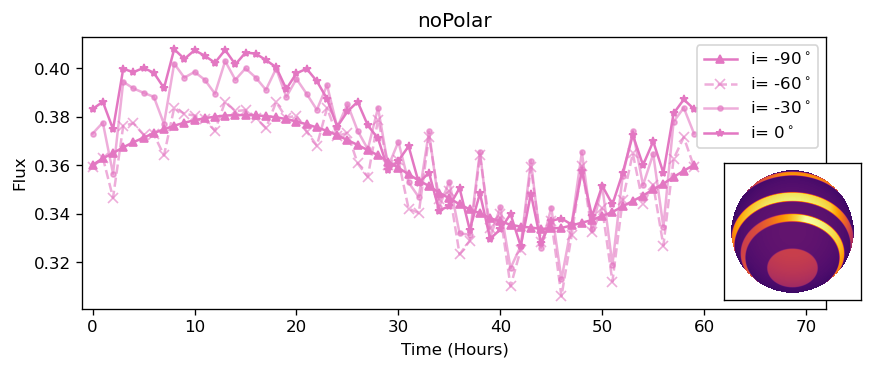

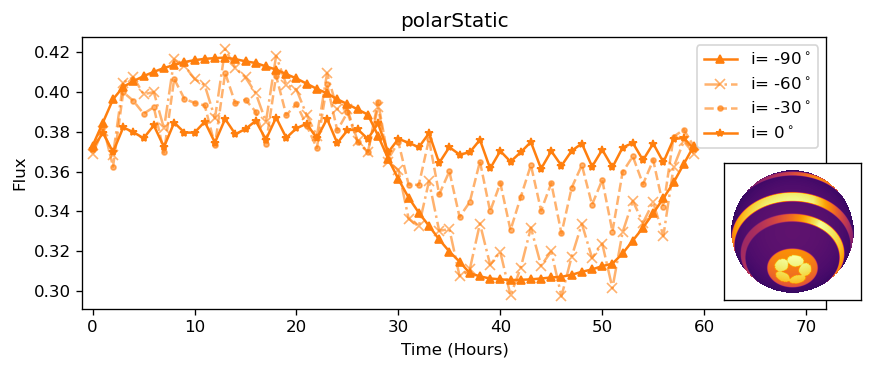

In [8]:
# ============================================================
# [[Plot]]
# Plot all norm_flux with time for each inclinations
# in each model classes
# ============================================================    
plt.close()
colorList = {'polarStatic':'tab:orange', 'noPolar':'tab:pink', 'polarDynamic':'k'}
markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
for model in modelclasses: 
    fig, ax1 = plt.subplots(dpi=120, figsize=(8,3))
    for iang in incli:
        y_flux = fluxes[model][iang]['norm']
        if iang == '-90' or iang =='0':
            line, = ax1.plot(time_array, y_flux, c=colorList[model],ls='-', 
                             marker=markList4[iang], alpha=1, lw=1.5, label=r'i= %s$^\circ$'%iang, ms=5)
        elif iang == '-30' or iang == '-60':
            line, = ax1.plot(time_array, y_flux, c=colorList[model],ls=next(linestyleRandomList), 
                             marker=markList4[iang], alpha=0.6, label=r'i= %s$^\circ$'%iang)
        ax1.set_xlim(-1, 72), ax1.set_xlabel('Time (Hours)'), ax1.set_ylabel('Flux')
        ax1.set_title(model)
        ax1.legend(loc='upper right')
        
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.675, 0.15, 0.38, 0.38]
    subax1 = fig.add_axes([left, bottom, width, height])
    subax1.imshow(images[model]['-50'][5][0], cmap='inferno')
    subax1.set_xticks([])
    subax1.set_yticks([])

#### 1D) [plot] Plot photometry by each feature-class region

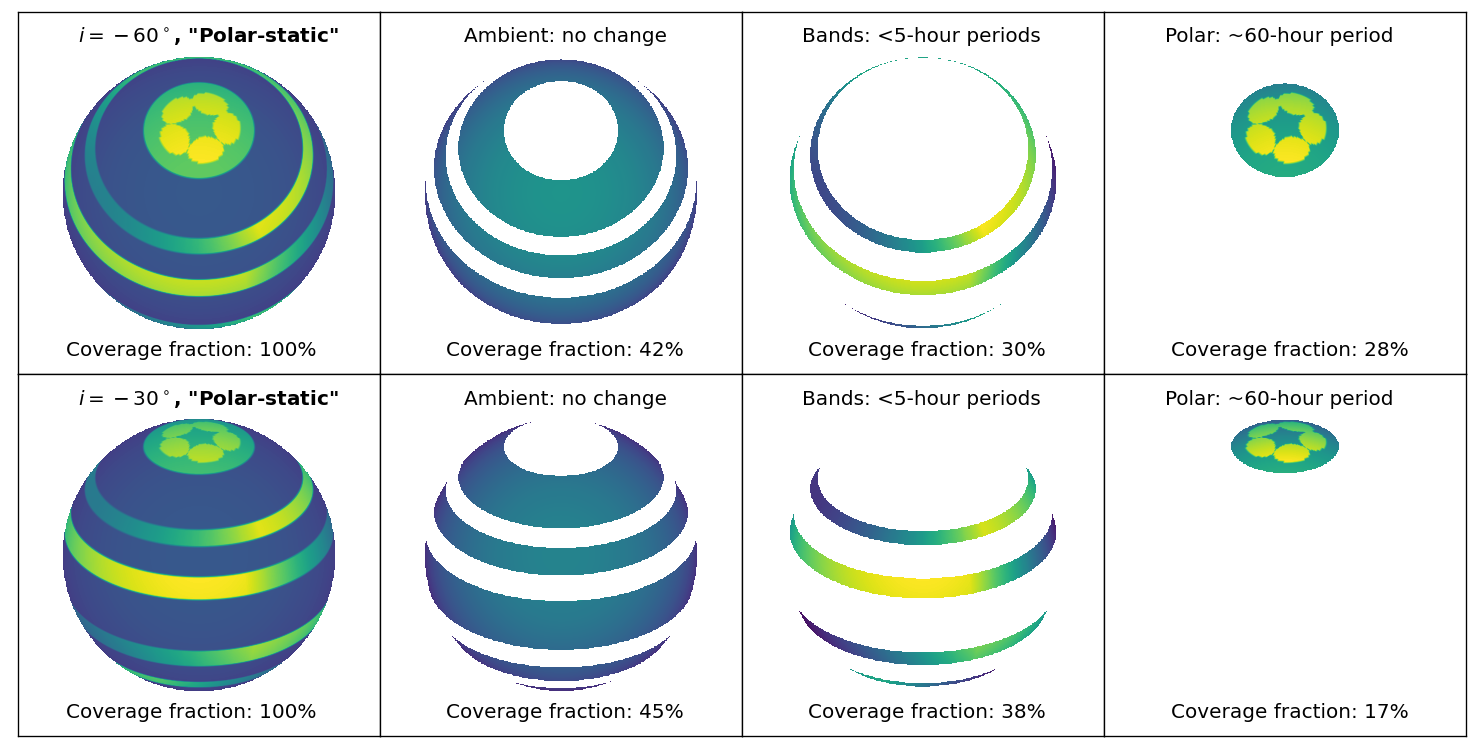

In [9]:
# ============================================================
# [[Plot]]
# Plot the total photometry, and each feature-class:
# ambient, band, pole
# ============================================================

# save = True
save = False

plt.close()
fig, axs = plt.subplots(2,4, figsize=(15.575, 8), dpi=120)
# modelnames = ['polarStatic', 'noPolar']
for ia, iang in enumerate(['-60', '-30']):
# inclination angle iang
    labelList = ['Total', 'Ambient', 'Band', 'Polar']

    for ib, array in enumerate(images['polarStatic'][iang][5]):
        axs[ia, ib].imshow(array)
        if iang=='-20': axs[ia, ib].set_title(labelList[ib])
        axs[ia, ib].set_xlim(-50, 550)
        axs[ia, ib].set_ylim(-50, 550)
        
for a in range(2):
    for b in range(4):
        axs[a, b].set_xticks([])
        axs[a, b].set_yticks([])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

### Annotate
model, iang = 'polarStatic', '-60'
fracA1 = fluxes[model][iang]['fraction']['amb']
fracB1 = fluxes[model][iang]['fraction']['band']
fracP1 = fluxes[model][iang]['fraction']['pol']

model, iang = 'polarStatic', '-30'
fracA2 = fluxes[model][iang]['fraction']['amb']
fracB2 = fluxes[model][iang]['fraction']['band']
fracP2 = fluxes[model][iang]['fraction']['pol']

# first row
axs[0,0].text(50, 500, r'$i=-60^\circ$, "Polar-static"', weight='bold', fontsize=12)
axs[0,0].text(30, -20, 'Coverage fraction: %i%%'%(100), fontsize=12)

axs[0,1].text(90, 500, 'Ambient: no change', fontsize=12)
axs[0,1].text(60, -20, 'Coverage fraction: %i%%'%(fracA1*100+2), fontsize=12)

axs[0,2].text(50, 500, 'Bands: <5-hour periods', fontsize=12)
axs[0,2].text(60, -20, 'Coverage fraction: %i%%'%(fracB1*100+2), fontsize=12)

axs[0,3].text(50, 500, 'Polar: ~60-hour period', fontsize=12)
axs[0,3].text(60, -20, 'Coverage fraction: %i%%'%(fracP1*100+2), fontsize=12)

# second row
axs[1,0].text(50, 500, r'$i=-30^\circ$, "Polar-static"', weight='bold', fontsize=12)
axs[1,0].text(30, -20, 'Coverage fraction: %i%%'%(100), fontsize=12)

axs[1,1].text(90, 500, 'Ambient: no change', fontsize=12)
axs[1,1].text(60, -20, 'Coverage fraction: %i%%'%(fracA2*100+3), fontsize=12)

axs[1,2].text(50, 500, 'Bands: <5-hour periods', fontsize=12)
axs[1,2].text(60, -20, 'Coverage fraction: %i%%'%(fracB2*100+2), fontsize=12)

axs[1,3].text(50, 500, 'Polar: ~60-hour period', fontsize=12)
axs[1,3].text(60, -20, 'Coverage fraction: %i%%'%(fracP2*100+2), fontsize=12)

if save:
    plotOut = plotPath + '/2x4_TypeCoverageFraction_inclination'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 1E) [plot] Plot flux evolution by inclination, model class, and feature class

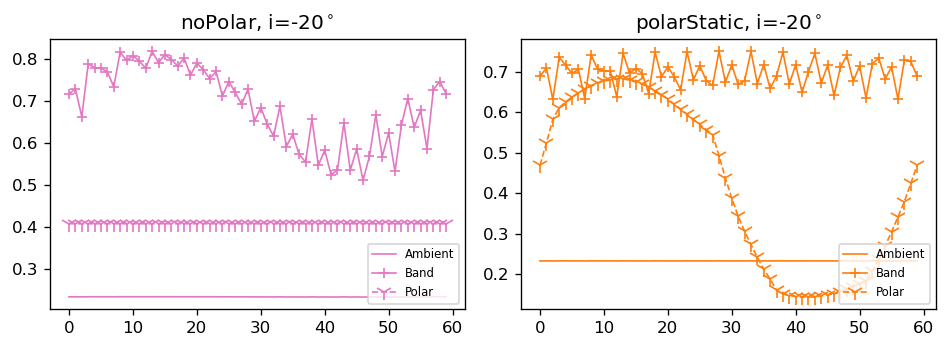

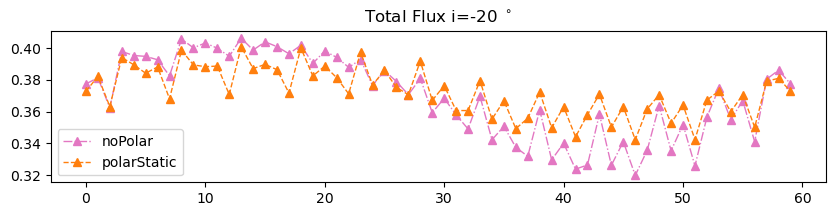

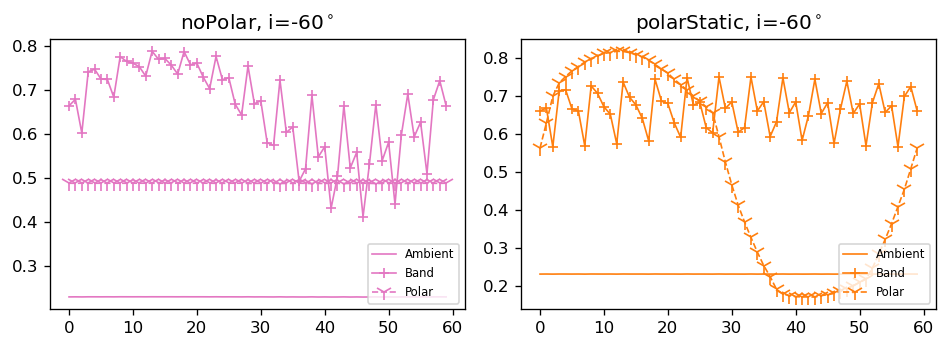

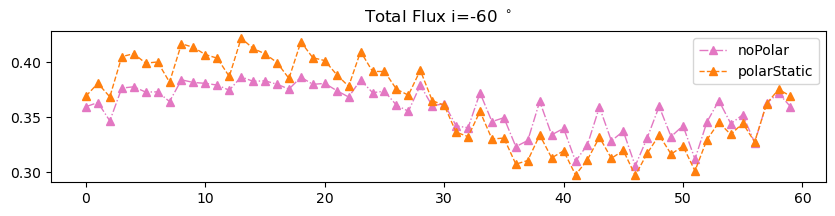

In [10]:
# ============================================================
# [[Plot]]
# Plot flux by class-type (ambient, band, polar) by 
# model class (polarStatic, polarDynamic, noPolar)
# for some inclination
# ============================================================    
plt.close()
colorList = {'polarStatic':'tab:orange', 'polarDynamic':'k', 'noPolar':'tab:pink'}
for ia, iang in enumerate(['-20', '-60']): 
    fig, axs = plt.subplots(1,2, dpi=120, figsize=(8,3))
    ticklist = {'b': '+', 'a':'', 'p':'1'}
    for i, model in enumerate(modelclasses):
        ambflux = fluxes[model][iang]['bytype']['amb']
        bandflux = fluxes[model][iang]['bytype']['band']
        polflux = fluxes[model][iang]['bytype']['pol']
        
        axs[i].plot(time_array, ambflux, ls='-', lw=1, c=colorList[model], alpha=1, label=r'Ambient', marker=ticklist['a'])
        axs[i].plot(time_array, bandflux, ls='-', lw=1, c=colorList[model], alpha=1, label=r'Band', marker=ticklist['b'])
        axs[i].plot(time_array, polflux, ls='--', lw=1, c=colorList[model], alpha=1, label=r'Polar', marker=ticklist['p'], ms=10)
        
        axs[i].set_title(model+r', i=%s$^\circ$'%iang)
        axs[i].legend(fontsize=7, loc='lower right')
        plt.tight_layout()
    
    plt.figure(figsize=(10, 2), dpi=100)
    plt.plot(time_array, fluxes['noPolar'][iang]['norm'], ls='-.', marker='^', c='tab:pink', lw=1, label='noPolar')
    plt.plot(time_array, fluxes['polarStatic'][iang]['norm'], ls='--', marker='^', c='tab:orange', lw=1, label='polarStatic')
    plt.title('Total Flux i=%s $^\circ$'%iang), plt.legend()

## Step 2: Generate Synthetic Spectra Cube with Sonora - Cloudy Vs. Less cloudy

#### 2A) [read, create, calculate, plot] Binning down Sonora Cloudless & Cloudy Model

In [11]:
cloudlessPath ='~/Documents/GitHub/polar_vortice/data/spectras/bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
cloudyPath = '~/Documents/GitHub/polar_vortice/data/spectras/diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'

cloudlessSpec = pd.read_csv(cloudlessPath, sep='\s+', names = ['wave', 'flux'], skiprows=2)
cloudlessSpec = cloudlessSpec.query(' 0.0 <= wave <= 15.09')
cloudlessSpec.sort_values('wave', inplace=True)

cloudySpec = pd.read_csv(cloudyPath, sep='\s+', names = ['wave', 'flux'], skiprows=3)
cloudySpec = cloudySpec.query(' 0.0 <= wave <= 15.09')
cloudySpec.sort_values('wave', inplace=True)

cloudlessSpec['norm'] = cloudlessSpec.flux / cloudlessSpec.flux.max()
cloudySpec['norm'] = cloudySpec.flux / cloudySpec.flux.max()

# set up color index center wavelength
lamJ, lamH = 1.10, 1.60
lamK = 2.20
lamContinuum = 1.275
lamwidth = 0.10

lamsilicate = [9.0, 9.6]
lamsilicateMean = np.mean(lamsilicate)
lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
lamcont1Mean, lamcont2Mean = np.mean(lamcont1), np.mean(lamcont2)

R=lamda/d_lamda= 974.648237203402


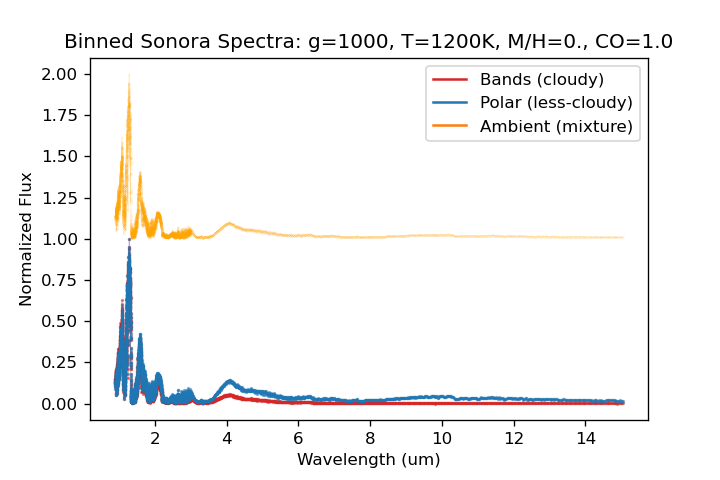

In [127]:
# %matplotlib inline
%matplotlib widget
# ================================================================================
# [[Plot]]
# Plot the binned flux, and output file for cloudy AND cloudless spectra
# idea: try searching a bin-reserving flux
# idea: try NIRSPEC resolution, R=2000
# ================================================================================
### Options
# save = True ## output spectra files
save = False
# ==== perform convolution of box-car smooth and plot spectras ===================
rebinning = False 
# rebinning = True

read = not rebinning ## reading existing, smoothed spectra
# ================================================================================
# Boxcar convolution for spectra binning
# ================================================================================
if rebinning:
    plt.close(), plt.figure(figsize=(12,6))
    # print(cloudySpec.norm.shape)
    # plt.plot(cloudySpec.wave, cloudySpec.norm)
    cloudy, cloudless = [], []
    binresolution = 2000
    binresolution = 50
    convolve_res = 50

    wavebin1 = convolve(cloudySpec.wave, Box1DKernel(convolve_res))[::binresolution]
    normbin1 = convolve(cloudySpec.norm, Box1DKernel(convolve_res))[::binresolution]
    # print(wavebin1.shape)

    wavebin2 = convolve(cloudlessSpec.wave, Box1DKernel(convolve_res))[::binresolution]
    normbin2 = convolve(cloudlessSpec.norm, Box1DKernel(convolve_res))[::binresolution]
    # print(wavebin2.shape)
    normbin2_interp = np.interp(x=wavebin1, xp=wavebin2, fp=normbin2)

    plt.plot(wavebin1, normbin1, ls='', marker='.', c='tab:red', label='cloudy (Diamondback)', alpha=0.5)
    plt.plot(wavebin1, normbin2_interp, ls='', marker='.', c='tab:blue', label='cloudless (Bobcat)', alpha=0.5)
    plt.plot(wavebin1, 0.1 + 0.1*(normbin2_interp+normbin1)/2, ls='', marker='', c='orange', label='averaged', alpha=0.7)

    R=1.5/np.diff(wavebin1).mean() 
    print('R=lamda/d_lamda=', R)
    # center wavelength near J and H band
    # plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5), plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)
    # plt.axvline(lamH-lamwidth, c='k', ls='-.', lw=0.5), plt.axvline(lamH+lamwidth, c='k', ls='-.', lw=0.5)
    # plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5), plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)
    
    # plt.xlim(0.90,2.390)
    plt.xlim(0.90,15.090)
    plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
    # ================================================================================
    ### Output binned spectras into text files
    # ================================================================================

    pathCloudyOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'%R
    cloudy = pd.DataFrame(np.transpose(np.array([wavebin1, normbin1])), columns=['wave','flux'])
    cloudy = cloudy.query('0.90 <= wave <= 15.09')
    cloudy.flux = cloudy.flux/cloudy.flux.max()
    if save: cloudy.to_csv(pathCloudyOut, index=False)

    pathCloudlessOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'%R
    cloudless = pd.DataFrame(np.transpose(np.array([wavebin1, normbin2_interp])), columns=['wave','flux'])
    cloudless = cloudless.query('0.90 <= wave <= 15.09')
    cloudless.flux = cloudless.flux/cloudless.flux.max()
    if save: cloudless.to_csv(pathCloudlessOut, index=False)

# ================================================================================
# read from existing saved spectras
# ================================================================================
if read:
    header = ['wave', 'flux']
    cloudy, cloudless = [], []
    # pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'
    pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'
    cloudy = pd.read_csv(pathCloudyOutput, names=header, skiprows=1)
    
    # pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
    pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'
    cloudless = pd.read_csv(pathCloudlessOutput, names=header, skiprows=1)
    
    plt.close(), plt.figure(figsize=(6,4), dpi=120)
    # print(cloudy.flux.shape)
    
    bandspec = cloudy.sort_values(by='wave').flux.iloc[:-1]
    fracConst = 0.15
    polarspec = (1-fracConst)*bandspec + fracConst*cloudless.sort_values(by='wave').flux.iloc[:-1]
    basespec = 1 + 0.5*bandspec + 0.5*polarspec
    lam = cloudy.sort_values(by='wave').wave.iloc[:-1]
    
    plt.plot(lam, bandspec, ls='-', marker='.', c='tab:red', alpha=0.5, ms=2, lw=0.2)
    plt.plot(lam, polarspec, ls='-', marker='.', c='tab:blue', alpha=0.5, ms=2, lw=0.2)
    plt.plot(lam, basespec, ls='-', marker='.', c='orange', alpha=0.4, ms=0.3, lw=0.2)
    
    # fake plot for better legend opacity 
    plt.plot([],[], c='tab:red', label='Bands (cloudy)')
    plt.plot([],[], c='tab:blue', label='Polar (less-cloudy)')
    plt.plot([],[], c='tab:orange', label='Ambient (mixture)')
             
    R=1.5/np.diff(cloudy.wave).mean() 
    print('R=lamda/d_lamda=', R)
    # center wavelength near J and H band
#     plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5)
#     plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)
    
#     plt.axvline(lamH-lamwidth, c='k', ls='--', lw=0.5)
#     plt.axvline(lamH+lamwidth, c='k', ls='--', lw=0.5)
    
#     plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5)
#     plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)
    
    plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Normalized Flux')
    plt.legend()          

#### [create, calculate, plot] Test: Calculate the silicate index

Text(0.5, 1.0, 'Silicate index for sample spectra "Cloudy"')

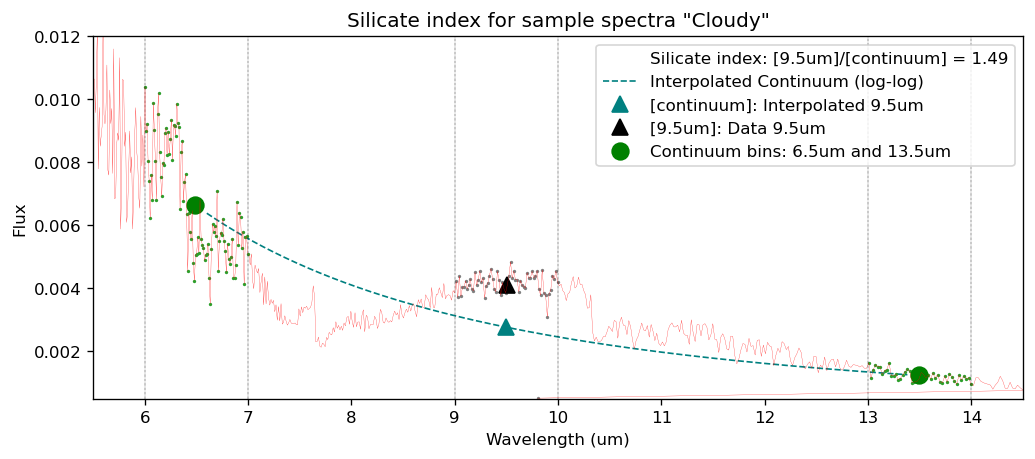

In [128]:
%matplotlib inline
# ============ Test the log-interpolation routine ==============
a1 = cloudy.query('6.<wave<7.').copy()
a2 = cloudy.query('13.<wave<14.').copy()
a3 = cloudy.query('9.<wave<10.').copy()

wavemean = np.array((a1.wave.mean(), a2.wave.mean()))
fluxmean = np.array((a1.flux.mean(), a2.flux.mean()))

### use log_interp1d
log_y = log_interp1d(wavemean, fluxmean, kind='linear')
xx = cloudy.query('6.6<=wave<=13.4').wave.sort_values()
yy = log_y(xx)

### plot the result
plt.close(), plt.figure(figsize=(10,4), dpi=120)
s = 'Silicate index: [9.5um]/[continuum] = %.2f'
plt.plot([],[], ls='', label=s%(a3.flux.mean()/log_y(9.5)))
# plot the log trendline
plt.plot(xx,yy,'--', c='teal', lw=1, label='Interpolated Continuum (log-log)')
plt.plot(9.5,log_y(9.5),ls='', marker='^', c='teal', ms=10, label='[continuum]: Interpolated 9.5um')
# plot the wave bins
plt.plot(a1.wave, a1.flux, ls='', marker='o', ms=1, c='tab:green')
plt.plot(a2.wave, a2.flux, ls='', marker='o', ms=1, c='tab:green')
plt.plot(a3.wave, a3.flux, ls='', marker='o', ms=1, c='gray')
# plot the silicate ratios
plt.plot(a3.wave.mean(), a3.flux.mean(), ls='', marker='^', c='k', ms=10, label='[9.5um]: Data 9.5um')
plt.plot(wavemean, fluxmean, ls='', marker='o', ms=10, c='green', label='Continuum bins: 6.5um and 13.5um')
# plot the wave bin barrier
[plt.axvline(_x, linewidth=0.25, color='k', ls='-.') for _x in [6, 7, 9, 10, 13, 14]]
# plot the spectra
plt.plot(cloudy.wave, cloudy.flux, c='r', lw=0.15)
plt.xlim(5.5, 14.5), plt.ylim(0.0005, 0.012)
# extra
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux')
plt.title('Silicate index for sample spectra "Cloudy"')

#### 2A2) [plot] 2x2 Figure Synthetic Atmosphere Model

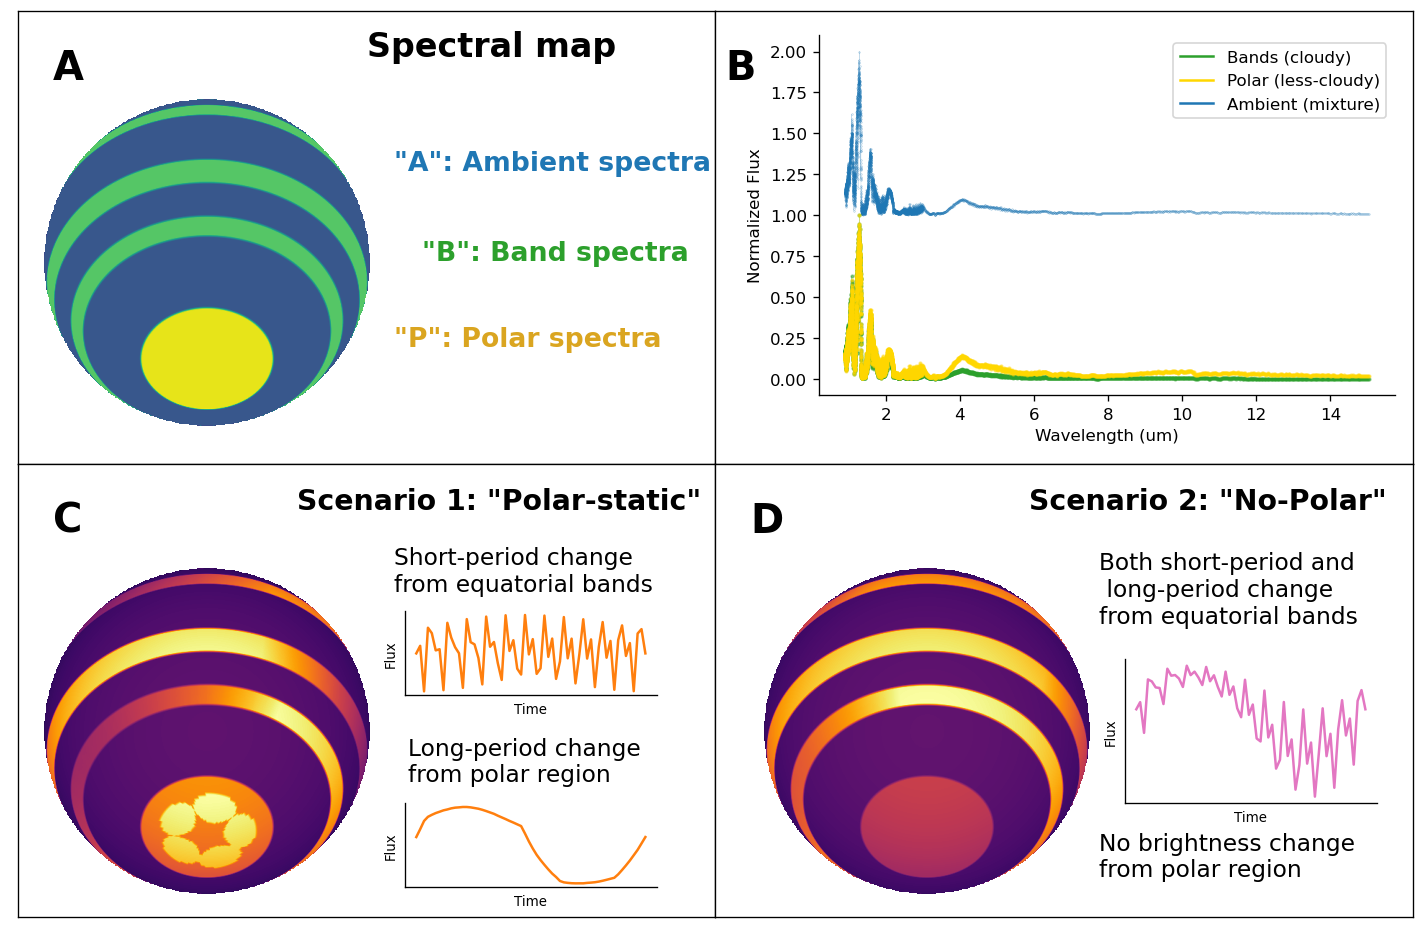

In [129]:
### 2x2 Figure Synthetic Atmosphere Model, Annotated Plots
save = False
# save = True

fig, axs = plt.subplots(2,2, figsize=(15, 10), dpi=120)
for a in range(2):
    for b in range(2):
        axs[a,b].set_xticks([])
        axs[a,b].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)

# ==================== Plot 1: Spectral map image ====================== 
left, bottom, width, height = [0.08, 0.52, 0.3, 0.3]
subax1 = fig.add_axes([left, bottom, width, height])
subax1.axis('off')
subax1.imshow(specmasks[model]['-50'][0], cmap='viridis')
subax1.set_xticks([])
subax1.set_yticks([])

# ==================== Plot 3: PolarStatic case ====================== 
left, bottom, width, height = [0.08, 0.13, 0.3, 0.3]
subax3 = fig.add_axes([left, bottom, width, height])
subax3.axis('off')
subax3.imshow(images['polarStatic']['-50'][5][0], cmap='inferno')
subax3.set_xticks([])
subax3.set_yticks([])

# subax3a: short-period band flux plot
left, bottom, width, height = [0.34, 0.31, 0.14, 0.07]
subax3a = fig.add_axes([left, bottom, width, height])
subax3a.plot(time_array, fluxes['polarStatic']['-50']['bytype']['band'], marker='', color='tab:orange')
subax3a.spines['top'].set_visible(False), subax3a.spines['right'].set_visible(False)
subax3a.set_xlabel('Time', fontsize=8), subax3a.set_ylabel('Flux', fontsize=8)
subax3a.set_xticks([])
subax3a.set_yticks([])

# subax3b: long-period polar flux plot
left, bottom, width, height = [0.34, 0.15, 0.14, 0.07]
subax3b = fig.add_axes([left, bottom, width, height])
subax3b.plot(time_array, fluxes['polarStatic']['-50']['bytype']['pol'], marker='', color='tab:orange')
subax3b.spines['top'].set_visible(False), subax3b.spines['right'].set_visible(False)
subax3b.set_xlabel('Time', fontsize=8), subax3b.set_ylabel('Flux', fontsize=8)
subax3b.set_xticks([])
subax3b.set_yticks([])

# ==================== Plot 4: NoPolar Case ==========================
left, bottom, width, height = [0.48, 0.13, 0.3, 0.3]
subax4 = fig.add_axes([left, bottom, width, height])
subax4.axis('off')
subax4.imshow(images['noPolar']['-50'][10][0], cmap='inferno')
subax4.set_xticks([])
subax4.set_yticks([])

# subax4a: noPolar band flux plot
left, bottom, width, height = [0.74, 0.22, 0.14, 0.12]
subax4a = fig.add_axes([left, bottom, width, height])
subax4a.plot(time_array, fluxes['noPolar']['-50']['bytype']['band'], marker='', color='tab:pink')
subax4a.spines['top'].set_visible(False), subax4a.spines['right'].set_visible(False)
subax4a.set_xlabel('Time', fontsize=8), subax4a.set_ylabel('Flux', fontsize=8)
subax4a.set_xticks([])
subax4a.set_yticks([])

# ============== Plot 2: The compositite spectra =====================
left, bottom, width, height = [0.57, 0.56, 0.32, 0.30]
subax2 = fig.add_axes([left, bottom, width, height])
# subax2.set_xticks([])
# subax2.set_yticks([])

subax2.plot(lam, basespec, ls='-', marker='.', c='tab:blue', alpha=0.4, ms=0.6, lw=0.2)
subax2.plot(lam, bandspec, ls='-', marker='.', c='tab:green', alpha=0.5, ms=3, lw=0.2)
subax2.plot(lam, polarspec, ls='-', marker='.', c='gold', alpha=0.5, ms=3, lw=0.2)

# fake plot for better legend opacity 
subax2.plot([],[], c='tab:green', label='Bands (cloudy)')
subax2.plot([],[], c='gold', label='Polar (less-cloudy)')
subax2.plot([],[], c='tab:blue', label='Ambient (mixture)')

subax2.spines['top'].set_visible(False), subax2.spines['right'].set_visible(False)
# subax2.spines['bottom'].set_visible(False)
# subax2.spines['left'].set_visible(False)

subax2.set_xlabel('Wavelength (um)')
subax2.set_ylabel('Normalized Flux')
subax2.legend(fontsize=10)        

#### Annotations =================================
# Axes.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, 
# arrowprops=None, annotation_clip=None, **kwargs)
# ===== Plot 1 =====
axs[0,0].text(0.05, 0.85, 'A', fontsize=24, weight='bold')
axs[0,0].text(0.50, 0.9, 'Spectral map', fontsize=20, weight='bold')

axs[0,0].text(0.54, 0.65, '"A": Ambient spectra', weight='bold', fontsize=16, color='tab:blue')
axs[0,0].text(0.58, 0.45, '"B": Band spectra', weight='bold', fontsize=16, color='tab:green')
axs[0,0].text(0.54, 0.26, '"P": Polar spectra', weight='bold', fontsize=16, color='goldenrod')

# ===== Plot 2 =====
axs[0,1].text(0.015, 0.85, 'B', fontsize=24, weight='bold')

# ===== Plot 3 =====
axs[1,0].text(0.05, 0.85, 'C', fontsize=24, weight='bold')
axs[1,0].text(0.40, 0.90, 'Scenario 1: "Polar-static"', weight='bold', fontsize=17)

axs[1,0].text(0.54, 0.72, 'Short-period change\nfrom equatorial bands', fontsize=14)
axs[1,0].text(0.56, 0.30, 'Long-period change\nfrom polar region', fontsize=14)

# ===== Plot 4 =====
axs[1,1].text(0.05, 0.85, 'D', fontsize=24, weight='bold')
axs[1,1].text(0.45, 0.90, 'Scenario 2: "No-Polar"', weight='bold', fontsize=17)

axs[1,1].text(0.55, 0.65, 'Both short-period and\n long-period change\nfrom equatorial bands', fontsize=14)
axs[1,1].text(0.55, 0.09, 'No brightness change\nfrom polar region', fontsize=14)

if save:
    plotOut = plotPath + '/2x2_synthetic_atmosphere_model'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2B) [read, create, calculate] Generate the spectral datacube

**Method of generate spectral cube:** 
- Obtain flux by feature-class type (`ambient`,`band`,`polar`): These types will be a function of:
    + Latitudinal distribution of each feature-class
    + and the inclination angle which affect the projected area of each feature-class
- Generate spectras by feature-class type (`ambient`,`band`,`polar`):
    + Use a constant 0.2 flux for `ambient`.
    + Use A% $\times$ Cloudless and (1-A)% $\times$ Cloudy for `polar`.
    + Use Sonora-Diamondback Cloudy for `band`.
- Final expression: `Total` = norm_mean( $\Sigma [$ $\text{Frac. area}(i) \times (1+\text{Flux} (i)) \times \text{Spectra} (i)]$ )

In [130]:
### outline the wavelength band to calculate color
Jband_index = np.where(np.logical_and((lamJ-lamwidth)<=lam, lam<=(lamJ+lamwidth)))[0].tolist()
Hband_index = np.where(np.logical_and((lamH-lamwidth)<=lam, lam<=(lamH+lamwidth)))[0].tolist()
Kband_index = np.where(np.logical_and((lamK-lamwidth)<=lam, lam<=(lamK+lamwidth)))[0].tolist()
continuum_index = np.where(np.logical_and((lamContinuum-lamwidth/2)<=lam, lam<=(lamContinuum+lamwidth/2)))[0].tolist()

### outline the wavelength band to calculate silicate index
# lamsilicate = [9.0, 9.6]
# lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
sili_index = np.where(np.logical_and(lamsilicate[0]<=lam, lam<=lamsilicate[1]))[0].tolist()
continuum1_index = np.where(np.logical_and(lamcont1[0]<=lam, lam<=lamcont1[1]))[0].tolist()
continuum2_index = np.where(np.logical_and(lamcont2[0]<=lam, lam<=lamcont2[1]))[0].tolist()

In [131]:
# ================================================================================
# Define spectras of ambient (basespec), 
# band (bandspec) and polar region (polarspec).
# ================================================================================
#### Output options
save = False
# save = True
testPlot = True
# testPlot = False

# ================================================================================
# Spectra cube configs
# ================================================================================

spectral_cube = nested_dict()

colorList = {'polarStatic':'tab:orange', 'polarDynamic':'k', 'noPolar':'tab:pink'}

for i, model in enumerate(modelclasses):
    for iang in incli:
        ambflux = fluxes[model][iang]['bytype']['amb']
        bandflux = fluxes[model][iang]['bytype']['band']
        polflux = fluxes[model][iang]['bytype']['pol']
        
        frac_amb = fluxes[model][iang]['fraction']['amb']
        frac_band = fluxes[model][iang]['fraction']['band']
        frac_pol = fluxes[model][iang]['fraction']['pol']
        
        # prepare spectral cube
        spectra_array, JHcolor_array = [], []
        JKcolor_array = []
        continuum_array = []
        silicateIndex_array = []
        
        for i,t in enumerate(time_array): 
            spectra_at_t = ambflux[i]*frac_amb*basespec + bandflux[i]*frac_band*bandspec + polflux[i]*frac_pol*polarspec
            jhcolor_at_t = np.mean(spectra_at_t.iloc[Jband_index]) - np.mean(spectra_at_t.iloc[Hband_index])
            jkcolor_at_t = np.mean(spectra_at_t.iloc[Jband_index]) - np.mean(spectra_at_t.iloc[Kband_index])
            continuumRatio = jhcolor_at_t/np.mean(spectra_at_t.iloc[continuum_index])
            
            spectra_array.append(spectra_at_t)
            JHcolor_array.append(jhcolor_at_t)
            JKcolor_array.append(jkcolor_at_t)
            continuum_array.append(continuumRatio)
            
            #### Calculate the silicate index
            sili_at_t = np.mean(spectra_at_t.iloc[sili_index])
            cont1_at_t = np.mean(spectra_at_t.iloc[continuum1_index])
            cont2_at_t = np.mean(spectra_at_t.iloc[continuum2_index])
            logY = log_interp1d((lamcont1Mean, lamcont2Mean), (cont1_at_t, cont2_at_t), kind='linear')
            siliIndex_at_t = sili_at_t / logY(lamsilicateMean)
            
            silicateIndex_array.append(siliIndex_at_t)
            
        spectral_cube[model][iang]['spectra'] = spectra_array
        spectral_cube[model][iang]['JH_color'] = JHcolor_array
        spectral_cube[model][iang]['JK_color'] = JKcolor_array
        spectral_cube[model][iang]['continuumRatio'] = continuum_array
        spectral_cube[model][iang]['silicateIndex'] = silicateIndex_array

#### 2B2) [plot] Spectra plot by model type

/var/folders/n_/ynkgs9fs2ts72fkcb79xcjlh0000gn/T/ipykernel_72858/459069196.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


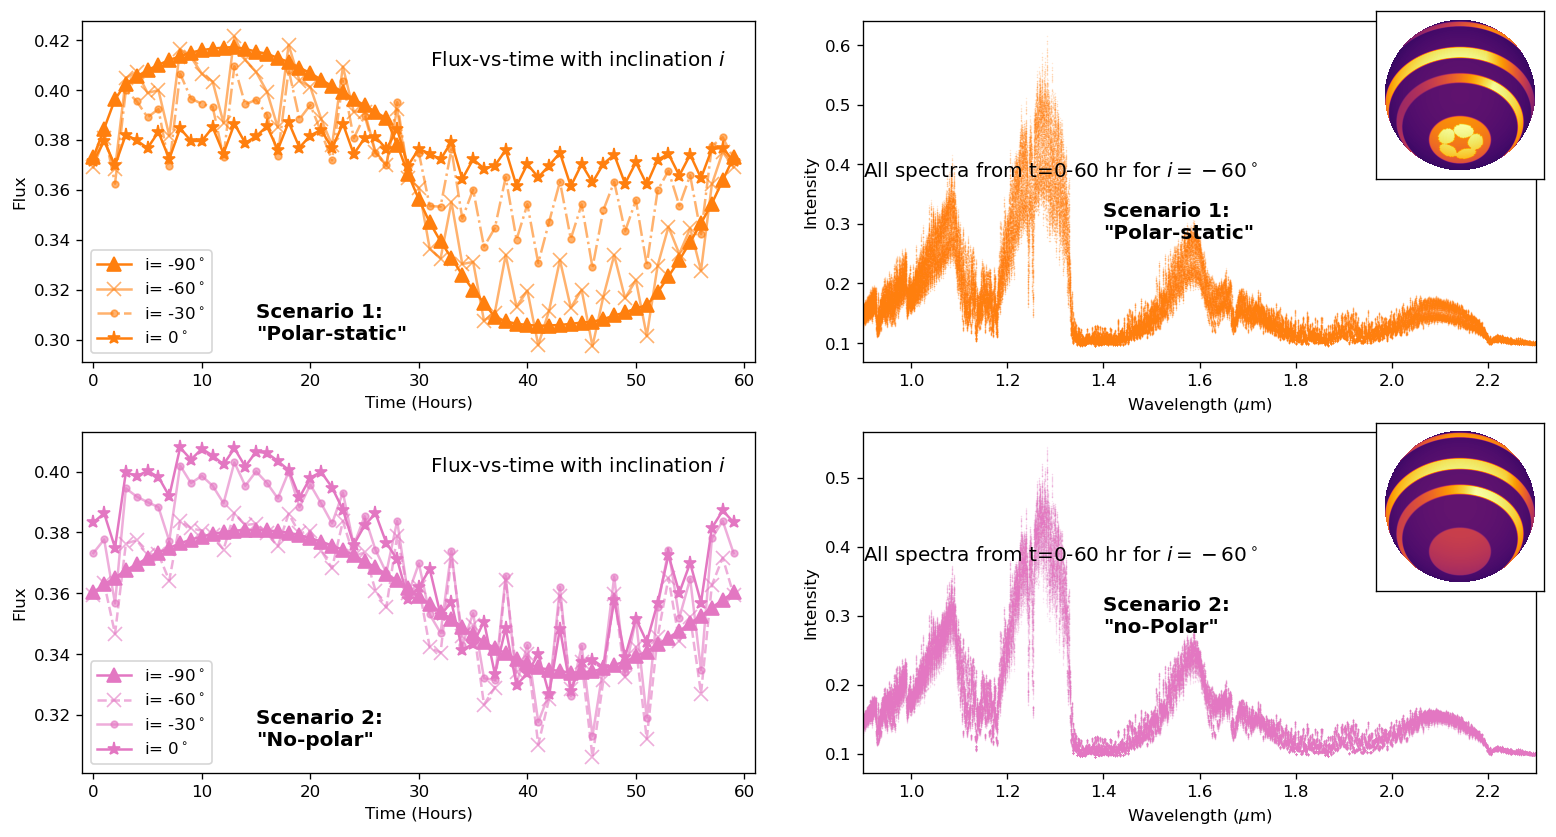

In [132]:
save = False
# save = True

fig, axs = plt.subplots(2,2, figsize=(13, 7), dpi=120)

### axs[0,0]: Plot 1: photometry polarStatic
colorList = {'polarStatic':'tab:orange', 'noPolar':'tab:pink', 'polarDynamic':'k'}
markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
model = 'polarStatic'
for iang in incli:
    y_flux = fluxes[model][iang]['norm']
    if iang == '-90' or iang =='0':
        line, = axs[0,0].plot(time_array, y_flux, c=colorList[model],ls='-', 
                         marker=markList4[iang], alpha=1, lw=1.5, label=r'i= %s$^\circ$'%iang, ms=8)
    elif iang == '-30' or iang == '-60':
        line, = axs[0,0].plot(time_array, y_flux, c=colorList[model],ls=next(linestyleRandomList), 
                         marker=markList4[iang], alpha=0.6, label=r'i= %s$^\circ$'%iang, ms=8)
    axs[0,0].set_xlim(-1, 61), axs[0,0].set_xlabel('Time (Hours)'), axs[0,0].set_ylabel('Flux')
    # axs[0,0].set_title(model)
    axs[0,0].legend(loc='lower left')
    
axs[0,0].text(15, 0.30, 'Scenario 1:\n"Polar-static"', fontsize=12, weight='bold')
axs[0,0].text(31, 0.41, r'Flux-vs-time with inclination $i$', fontsize=12)
    
### axs[1,0]: Plot 3: photometry noPolar
colorList = {'polarStatic':'tab:orange', 'noPolar':'tab:pink', 'polarDynamic':'k'}
markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
model = 'noPolar'
for iang in incli:
    y_flux = fluxes[model][iang]['norm']
    if iang == '-90' or iang =='0':
        line, = axs[1,0].plot(time_array, y_flux, c=colorList[model],ls='-', 
                         marker=markList4[iang], alpha=1, lw=1.5, label=r'i= %s$^\circ$'%iang, ms=8)
    elif iang == '-30' or iang == '-60':
        line, = axs[1,0].plot(time_array, y_flux, c=colorList[model],ls=next(linestyleRandomList), 
                         marker=markList4[iang], alpha=0.6, label=r'i= %s$^\circ$'%iang, ms=8)
    axs[1,0].set_xlim(-1, 61), axs[1,0].set_xlabel('Time (Hours)'), axs[1,0].set_ylabel('Flux')
    # axs[1,0].set_title(model)
    axs[1,0].legend(loc='lower left')
    
axs[1,0].text(15, 0.31, 'Scenario 2:\n"No-polar"', fontsize=12, weight='bold')
axs[1,0].text(31, 0.40, r'Flux-vs-time with inclination $i$', fontsize=12)

### axs[0,1]: Plot 2: spectra polarStatic
model = 'polarStatic'
iang = '-60'
for t in range(len(time_array)):
    linestyle = next(linestyleRandomList)
    specnum = spectral_cube[model][iang]['spectra'][t]
    axs[0,1].plot(lam, specnum, ls=linestyle, lw=0.0, marker='+', ms=0.1, c='tab:orange', alpha=0.5)
# axs[0,1].set_ylim(0.0, 0.42)
axs[0,1].set_xlim(0.9, 2.30)
axs[0,1].set_xlabel(r'Wavelength ($\mu$m)')
axs[0,1].set_ylabel('Intensity')
    
axs[0,1].text(1.4, 0.275, 'Scenario 1:\n"Polar-static"', fontsize=12, weight='bold')
axs[0,1].text(0.9, 0.38, 'All spectra from t=0-60 hr for $i=-60^\circ$', fontsize=12)

### axs[1,0]: Plot 4: spectra noPolar
model = 'noPolar'
iang = '-60'
for t in range(len(time_array)):
    linestyle = next(linestyleRandomList)
    specnum = spectral_cube[model][iang]['spectra'][t]
    axs[1,1].plot(lam, specnum, ls=linestyle, lw=0.0, marker='+', ms=0.1, c='tab:pink', alpha=0.5)
# axs[1,1].set_ylim(0.0, 0.42)
axs[1,1].set_xlim(0.9, 2.30)
axs[1,1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1,1].set_ylabel('Intensity')

axs[1,1].text(1.4, 0.275, 'Scenario 2:\n"no-Polar"', fontsize=12, weight='bold')
axs[1,1].text(0.9, 0.38, 'All spectra from t=0-60 hr for $i=-60^\circ$', fontsize=12)

# =========== subaxes ===========================

# subax1: display polarStatic image
left, bottom, width, height = [0.84, 0.79, 0.2, 0.2]
subax1 = fig.add_axes([left, bottom, width, height])
subax1.imshow(images['polarStatic']['-50'][5][0], cmap='inferno')
subax1.set_xticks([])
subax1.set_yticks([])

# subax2: display noPolar image
left, bottom, width, height = [0.84, 0.30, 0.2, 0.2]
subax2 = fig.add_axes([left, bottom, width, height])
subax2.imshow(images['noPolar']['-50'][5][0], cmap='inferno')
subax2.set_xticks([])
subax2.set_yticks([])

# ending options
plt.tight_layout()

if save:
    plotOut = plotPath + '/2x2_photometry_and_spectra_ByScenario'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2C) [plot] Spectra cube plot: all spectras through time, and J-H + J-Ks color by model class

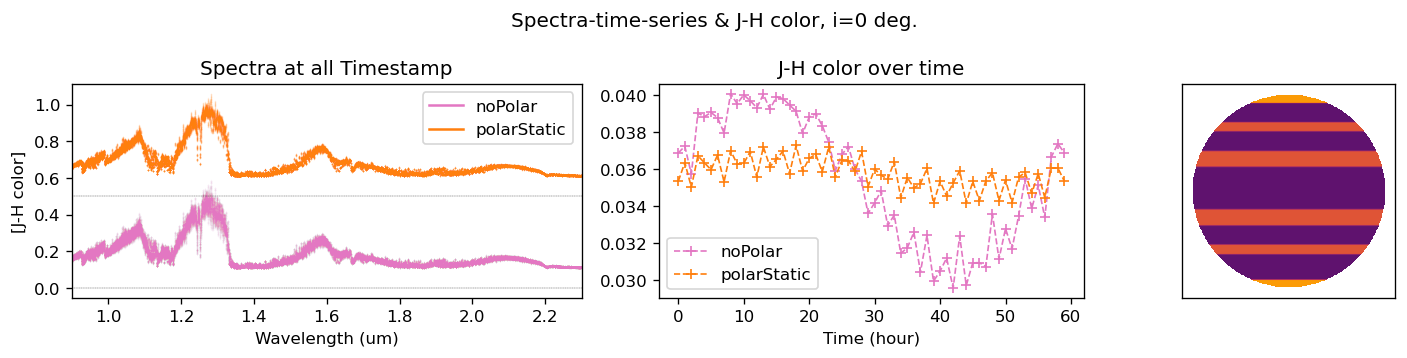

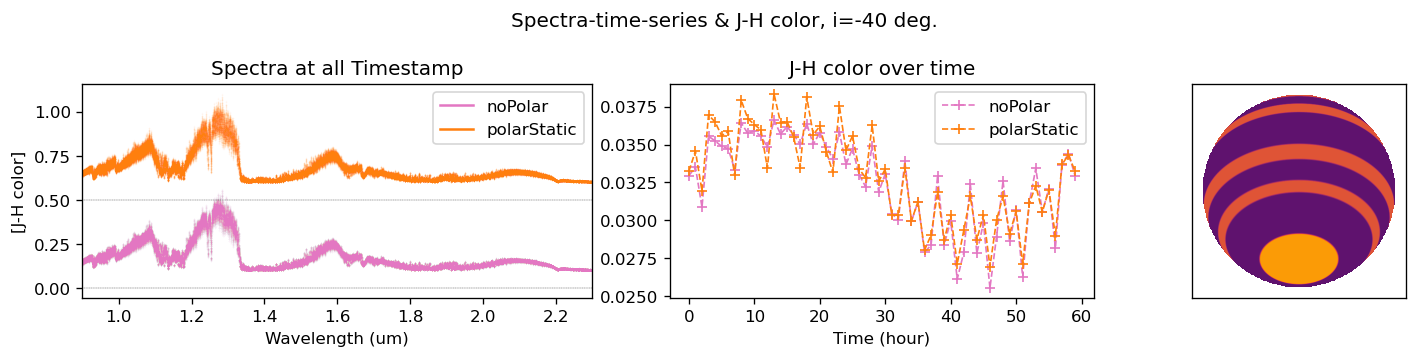

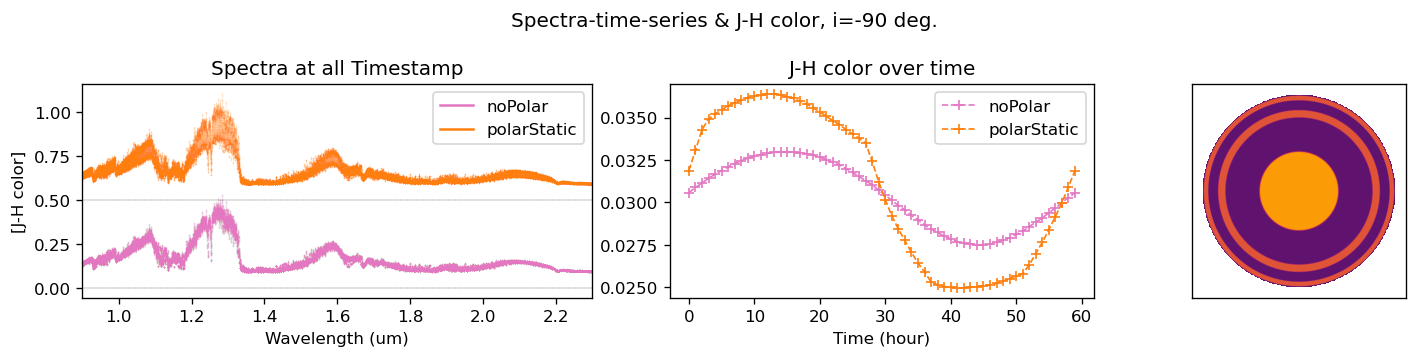

In [133]:
%matplotlib inline
# ================================================================================
# [[Plot]]
# Spectra cube test plots for two inclination, by model class 
# 1) spectras at all timestamps, two model classes: blue and red
# 2) j-h color evolution by time, two model classes: blue and red
# ================================================================================
plt.close()
for iang in ['0','-40','-90']:
    f, axs = plt.subplots(1, 3, figsize=(12,3), dpi=120, gridspec_kw={'width_ratios':[3, 2.5, 1.5]})
    cadence = (t1-t0)/no_frame
    f.suptitle('Spectra-time-series & J-H color, i=%s deg.'%iang)
    
    axs[0].set_title('Spectra at all Timestamp')
    axs[1].set_title('J-H color over time')
    
    offset = [0., 0.5]
    for i, model in enumerate(modelclasses):
        linestyle = next(linestyleRandomList)
        for t in range(len(time_array)):
            specnum = spectral_cube[model][iang]['spectra'][t]
            axs[0].plot(lam, specnum +offset[i], ls=linestyle, lw=0, marker='+', ms=0.02, c=colorList[model], alpha=0.5)
        
        axs[0].plot([], c=colorList[model], label=model)
        axs[0].legend()
        axs[0].set_xlabel('Wavelength (um)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_xlim(0.9, 2.30)
        axs[0].axhline(offset[i], ls='--', lw=0.2, c='k')

        colorArray = spectral_cube[model][iang]['JH_color']
        axs[1].plot(time_array, colorArray, c=colorList[model], ls='--', lw=1, marker='+', ms=6, label=model)
        axs[1].legend()
        axs[0].set_ylabel('[J-H color]')
        axs[1].set_xlabel('Time (hour)')
        
        axs[2].imshow(specmasks[model][iang][0], cmap='inferno', vmax=0.85, vmin=0.)
        axs[2].set_xticks([]), axs[2].set_yticks([])
        
    plt.tight_layout()

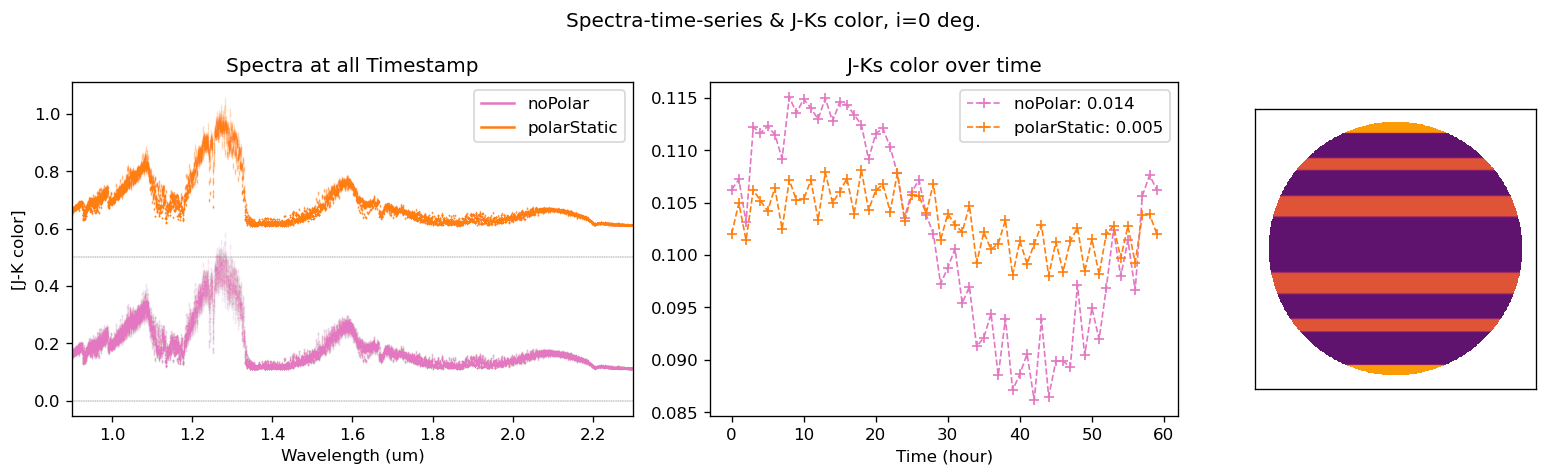

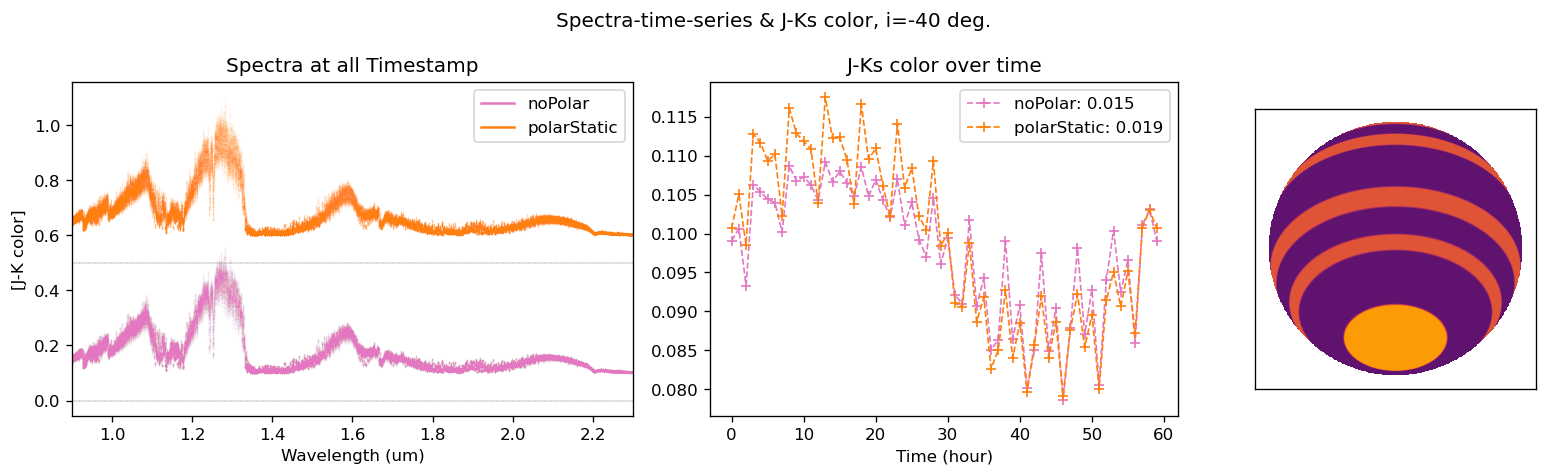

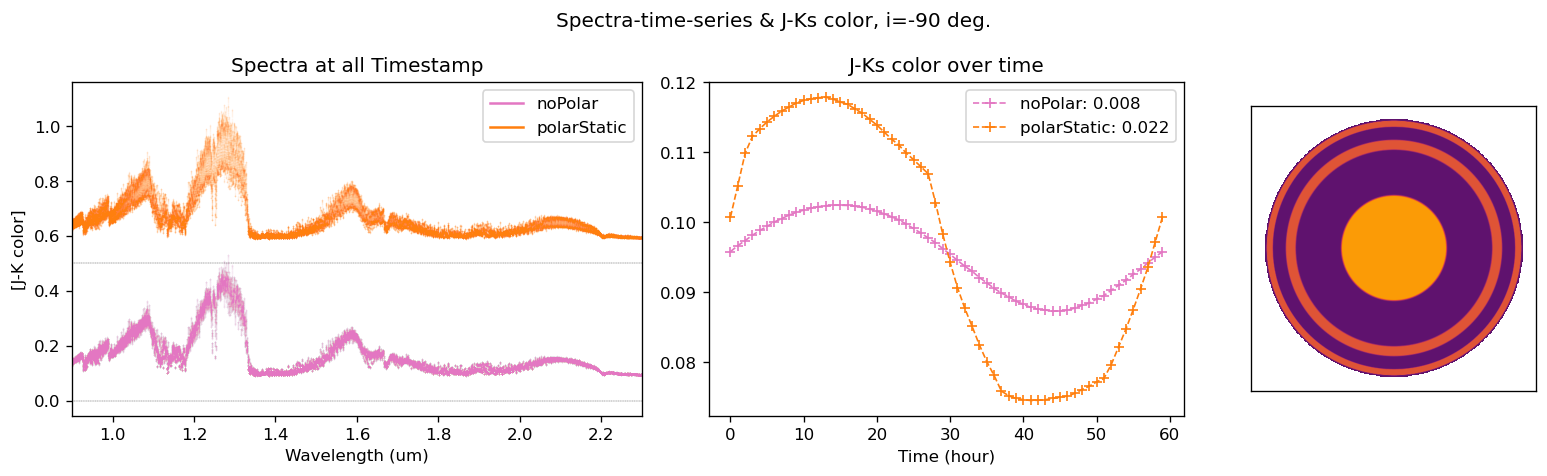

In [134]:
%matplotlib inline
# ================================================================================
# [[Plot]]
# Spectra cube test plots for two inclination, by model class 
# 1) spectras at all timestamps, two model classes: blue and red
# 2) j-h color evolution by time, two model classes: blue and red
# ================================================================================
plt.close()
for iang in ['0', '-40', '-90']:
    f, axs = plt.subplots(1, 3, figsize=(13,4), dpi=120, gridspec_kw={'width_ratios':[3, 2.5, 1.5]})
    cadence = (t1-t0)/no_frame
    f.suptitle('Spectra-time-series & J-Ks color, i=%s deg.'%iang)
    
    axs[0].set_title('Spectra at all Timestamp')
    axs[1].set_title('J-Ks color over time')
    
    offset = [0., 0.5]
    for i, model in enumerate(modelclasses):
        linestyle = next(linestyleRandomList)
        for t in range(len(time_array)):
            specnum = spectral_cube[model][iang]['spectra'][t]
            axs[0].plot(lam, specnum +offset[i], ls=linestyle, lw=0, marker='+', ms=0.02, c=colorList[model], alpha=0.5)
        
        axs[0].plot([], c=colorList[model], label=model)
        axs[0].legend()
        axs[0].set_xlabel('Wavelength (um)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_xlim(0.9, 2.30)
        axs[0].axhline(offset[i], ls='--', lw=0.2, c='k')

        colorArray = spectral_cube[model][iang]['JK_color']
        amp = (np.max(colorArray)-np.min(colorArray))/2
        axs[1].plot(time_array, colorArray, c=colorList[model], ls='--', lw=1, marker='+', ms=6, label=model+': %.3f'%amp)
        axs[1].legend()
        axs[0].set_ylabel('[J-K color]')
        axs[1].set_xlabel('Time (hour)')
        
        axs[2].imshow(specmasks[model][iang][0], cmap='inferno', vmax=0.85, vmin=0.)
        axs[2].set_xticks([]), axs[2].set_yticks([])
        
    plt.tight_layout()

#### 2E) [read, create, calculate, plot] Calculate time-averaged 'Amplitudes', as function of inclination for model class

**Definition of variation amplitude:** $\text{Amp}(x) = (\text{max}(x) - \text{min}(x))/2$

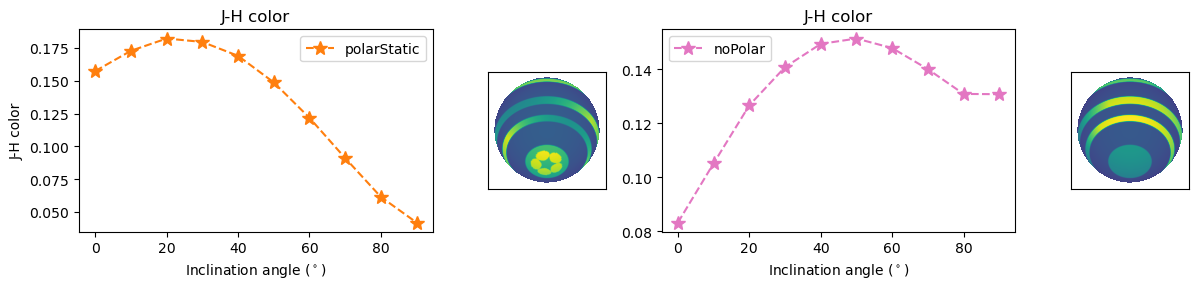

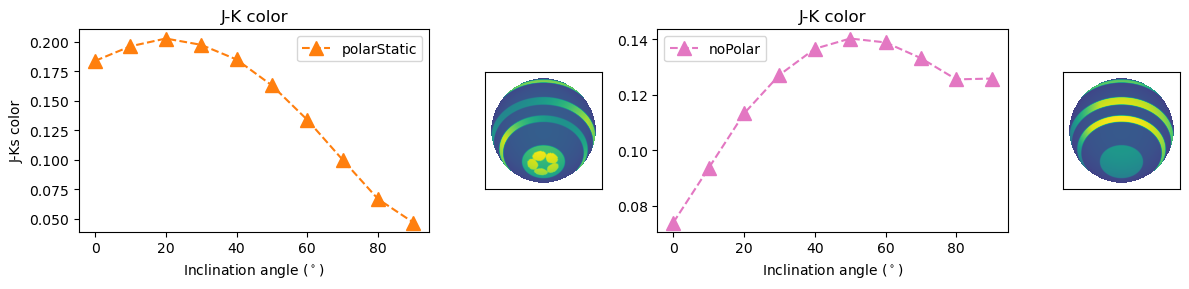

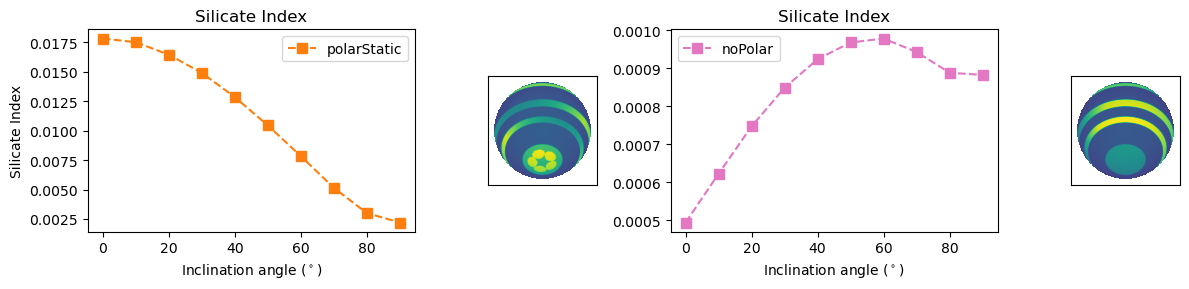

In [135]:
# ================================================================================
# [[Plot]]
# Quantify the variability amplitudes as a function of inclination
# by model class
# (1) J-H color
# (2) [J-H color]/[continuum]
# (3) J-Ks color
# ================================================================================
%matplotlib inline
amplitudes = nested_dict()
for model in modelclasses:
    # empty arrays
    emp1, emp2, emp3, emp4 = [], [], [], []
    # print(model)
    for iang in incli:
        continuumArray = np.array(spectral_cube[model][iang]['continuumRatio'])
        colorArrayJH = np.array(spectral_cube[model][iang]['JH_color'])
        colorArrayJK = np.array(spectral_cube[model][iang]['JK_color'])
        silicateArray = np.array(spectral_cube[model][iang]['silicateIndex'])
        
        #### amplitudes by taking middle value, then normalize
        ampColorJH = (colorArrayJH.max()-colorArrayJH.min())/2 / colorArrayJH.max()
        ampColorJK = (colorArrayJK.max()-colorArrayJK.min())/2 / colorArrayJK.max()
        ampContinuumRatio = (continuumArray.max()-continuumArray.min())/2 / continuumArray.max()
        ampSilicateIndex = (silicateArray.max()-silicateArray.min())/2 / silicateArray.max()
        
        ### summing through time
        # ampColorJH = colorArrayJH.sum()
        # ampColorJK = colorArrayJK.sum()
        # ampContinuumRatio = continuumArray.sum()
        
        emp1.append([int(iang), ampColorJH])
        emp2.append([int(iang), ampContinuumRatio]) 
        emp3.append([int(iang), ampColorJK])
        emp4.append([int(iang), ampSilicateIndex])
        
    amplitudes[model]['JH_color'] = np.array(emp1)
    amplitudes[model]['continuumRatio'] = np.array(emp2)
    amplitudes[model]['JK_color'] = np.array(emp3)
    amplitudes[model]['silicateIndex'] = np.array(emp4)
    
    # print('================')
    # print(amplitudes[model]['JH_color'])
    
# ==========================================================
## The plot: J-H color
# ==========================================================
plt.close()
titles = ['No polar variation', 'With polar variation']
# for typename in ['JH_color', 'continuumRatio']:
for typename in ['JH_color']:
    fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=100, gridspec_kw={'width_ratios':[3, 1, 3, 1]})
    # fig.suptitle('%s with inclination i'%typename)
    for i, model in enumerate(['polarStatic', 'noPolar']):
        x = amplitudes[model][typename][:,0]
        y = amplitudes[model][typename][:,1]
        axs[2*i].plot(x+90, y, ls='--', marker='*', c=colorList[model], ms=10, label=model)
        axs[2*i].legend()
        axs[2*i].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[2*i].set_title('J-H color')
    # axs[0].text(-90, 0.0025, 'Pole-on', fontsize=8), axs[0].text(-18, 0.0025, 'Equator-on', fontsize=8)
    # axs[2].text(-90, 0.006, 'Pole-on', fontsize=8), axs[2].text(-18, 0.006, 'Equator-on', fontsize=8)
    axs[0].set_ylabel('J-H color')
    
    time1 = 2
    axs[1].imshow(images['polarStatic']['-50'][time1][0]) 
    axs[1].set_xticks([]), axs[1].set_yticks([])
    time2 = 3
    axs[3].imshow(images['noPolar']['-50'][time2][0])  
    axs[3].set_xticks([]), axs[3].set_yticks([])
    plt.tight_layout()

# ==========================================================
## The plot: J-Ks color
# ==========================================================
titles = ['No polar variation', 'With polar variation']
# for typename in ['JH_color', 'continuumRatio']:
for typename in ['JK_color']:
    fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=100, gridspec_kw={'width_ratios':[3, 1, 3, 1]})
    # fig.suptitle('%s with inclination i'%typename)
    for i, model in enumerate(['polarStatic', 'noPolar']):
        x = amplitudes[model][typename][:,0]
        y = amplitudes[model][typename][:,1]
        axs[2*i].plot(x+90, y, ls='--', marker='^', c=colorList[model], ms=10, label=model)
        axs[2*i].legend()
        axs[2*i].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[2*i].set_title('J-K color')
    # axs[0].text(-90, 0.0025, 'Pole-on', fontsize=8), axs[0].text(-18, 0.0025, 'Equator-on', fontsize=8)
    # axs[2].text(-90, 0.006, 'Pole-on', fontsize=8), axs[2].text(-18, 0.006, 'Equator-on', fontsize=8)
    axs[0].set_ylabel('J-Ks color')
    
    time1 = 2
    axs[1].imshow(images['polarStatic']['-50'][time1][0]) 
    axs[1].set_xticks([]), axs[1].set_yticks([])
    time2 = 3
    axs[3].imshow(images['noPolar']['-50'][time2][0])  
    axs[3].set_xticks([]), axs[3].set_yticks([])
    plt.tight_layout()
    
# ==========================================================
## The plot: silicate Index
# ==========================================================
titles = ['No polar variation', 'With polar variation']
# for typename in ['JH_color', 'continuumRatio']:
for typename in ['silicateIndex']:
    fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=100, gridspec_kw={'width_ratios':[3, 1, 3, 1]})
    # fig.suptitle('%s with inclination i'%typename)
    for i, model in enumerate(['polarStatic', 'noPolar']):
        x = amplitudes[model][typename][:,0]
        y = amplitudes[model][typename][:,1]
        axs[2*i].plot(x+90, y, ls='--', marker='s', c=colorList[model], ms=7, label=model)
        axs[2*i].legend()
        axs[2*i].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[2*i].set_title('Silicate Index')
    # axs[0].text(-90, 0.0025, 'Pole-on', fontsize=8), axs[0].text(-18, 0.0025, 'Equator-on', fontsize=8)
    # axs[2].text(-90, 0.006, 'Pole-on', fontsize=8), axs[2].text(-18, 0.006, 'Equator-on', fontsize=8)
    axs[0].set_ylabel('Silicate Index')
    
    time1 = 2
    axs[1].imshow(images['polarStatic']['-50'][time1][0]) 
    axs[1].set_xticks([]), axs[1].set_yticks([])
    time2 = 3
    axs[3].imshow(images['noPolar']['-50'][time2][0])  
    axs[3].set_xticks([]), axs[3].set_yticks([])
    plt.tight_layout()

#### 2F1) [plot] Publication-ready Color/inclination plots: J-H color

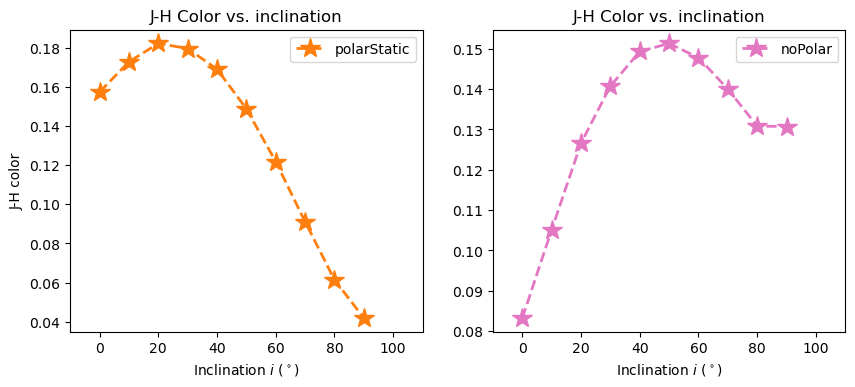

In [103]:
%matplotlib inline
# ==========================================================
## The plot: J-H color, revised, publication ready
# ==========================================================
save = False
# save = True
plt.close()
titles = ['J-H Color vs. inclination', 'J-H Color vs. inclination']

typename = 'JH_color'
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=100)

for i, model in enumerate(['polarStatic', 'noPolar']):
    x = amplitudes[model][typename][:,0]+90
    y = amplitudes[model][typename][:,1]
    axs[i].plot(x, y, ls='--', lw=2, marker='*', c=colorList[model], ms=15, label=model)
    axs[i].legend()
    axs[i].set_xlabel(r'Inclination $i$ ($^\circ$)')
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].set_xlim(-10, 110)

# axs[0].text(85, 0.0080, 'Equator-on', fontsize=10)
# axs[0].text(-2, 0.0080, 'Pole-on', fontsize=10)
# # axs[0].text(0, 0.003, 'Scenario 1: "Polar-static"', fontsize=14, weight='bold')

# axs[1].text(85, 0.004, 'Equator-on', fontsize=10)
# axs[1].text(-2, 0.004, 'Pole-on', fontsize=10)
# # axs[1].text(35, 0.0022, 'Scenario 2: "No-polar"', fontsize=14, weight='bold')

axs[0].set_ylabel('J-H color', fontsize=10)

if save:
    plotOut = plotPath + '/1x2_JHcolor_vs_inclinationTrend_byScenario'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2F2) [plot] Publication-ready Color/inclination plots: J-K color

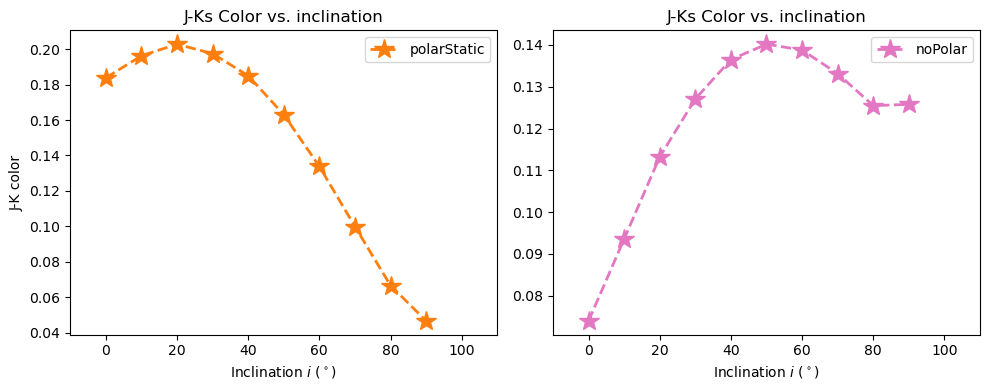

In [99]:
# ==========================================================
## The plot: J-K color, revised, publication ready
# ==========================================================
%matplotlib inline
save = False
# save = True

plt.close()
titles = ['J-Ks Color vs. inclination', 'J-Ks Color vs. inclination']

typename = 'JK_color'
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=100)

for i, model in enumerate(['polarStatic', 'noPolar']):
    x = amplitudes[model][typename][:,0]+90
    y = amplitudes[model][typename][:,1]
    axs[i].plot(x, y, ls='--', lw=2, marker='*', c=colorList[model], ms=15, label=model)
    axs[i].legend()
    axs[i].set_xlabel(r'Inclination $i$ ($^\circ$)')
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].set_xlim(-10, 110)

axs[0].set_ylabel('J-K color', fontsize=10)
plt.tight_layout()

if save:
    plotOut = plotPath + '/1x2_JKcolor_vs_inclinationTrend_byScenario'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2F2) [plot] Publication-ready Color/inclination plots: silicateIndex-inclination plot

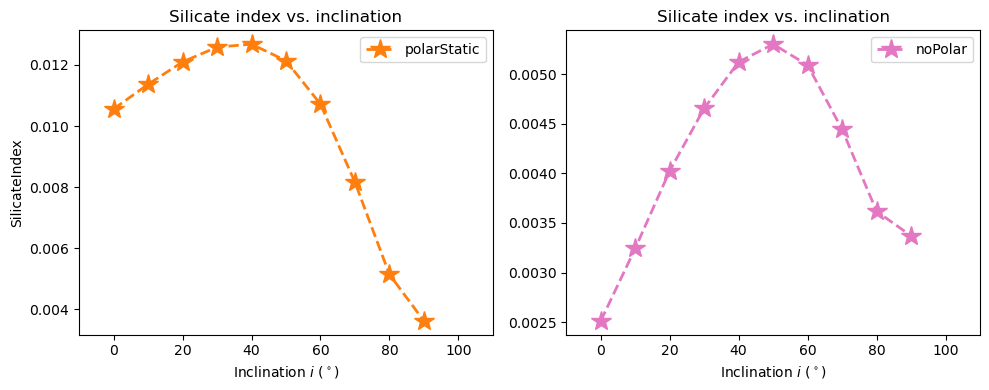

In [73]:
# ==========================================================
## The plot: J-K color, revised, publication ready
# ==========================================================

save = False
# save = True

plt.close()
titles = ['Silicate index vs. inclination', 'Silicate index vs. inclination']

typename = 'silicateIndex'
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=100)

for i, model in enumerate(['polarStatic', 'noPolar']):
    x = amplitudes[model][typename][:,0]+90
    y = amplitudes[model][typename][:,1]
    axs[i].plot(x, y, ls='--', lw=2, marker='*', c=colorList[model], ms=15, label=model)
    axs[i].legend()
    axs[i].set_xlabel(r'Inclination $i$ ($^\circ$)')
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].set_xlim(-10, 110)

axs[0].set_ylabel('SilicateIndex', fontsize=10)
plt.tight_layout()

if save:
    plotOut = plotPath + '/1x2_silicateIndex_vs_inclinationTrend_byScenario'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

## Step 3: Reproduce plots in literature

#### 3A) [read, create] Read external datas and plots
- Vos 2017:
    + **Color anomaly**: Median 2MASS J−Ks color subtracted from the J−Ks color of the objects. Median colors for L0–T6 objects were taken from Schmidt et al. (2010). T7 J−Ks color to be −0.04±0.43
- Suarez 2023:
    + Table 1: Silicate index
    + Table 2: Colors

In [1110]:
# =========== Vos 2017 Data ===============
vos17dataPath = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/vos_2017_table.csv"
nameList = ['Spt','3.6Amp','3.6AmpErr','JAmp','JAmpErr','KepAmp',
            'Period','PeriodErr','vsini','vsiniErr','JKscolor',
            'Inclination','inclinationErr','JKanomaly','JKanomalyErr']
v17data = pd.read_csv(vos17dataPath, names=nameList, delimiter=';', skiprows=1)

# =========== Suarez 2023 Data ===============
suarez23table1Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table1.csv"
suarez23table1Name = ["2MASSName","ShortName"," SpT(opt)",
                      "Reference1","SpT(IR)","Reference2","SilicateIndex",
                      "Si_err","Inc","IncErr","Reference"]
suarez23table1 = pd.read_csv(suarez23table1Path, delimiter=',', names=suarez23table1Name, skiprows=1)
### 
suarez23table2Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table2.csv"
suarez23table2Name = ["ShortName","J","Jerr","H","Herr",
                      "Ks","Kserr","W1","W1err",
                      "W2","W2err","J-Ks","W1-W2"]
suarez23table2 = pd.read_csv(suarez23table2Path, names=suarez23table2Name, delimiter=',', skiprows=1)
###
suarez23 = suarez23table2.merge(suarez23table1, on='ShortName', how='right')
suarez23['J-H'] = suarez23.J - suarez23.H
suarez23.columns

Index(['ShortName', 'J', 'Jerr', 'H', 'Herr', 'Ks', 'Kserr', 'W1', 'W1err',
       'W2', 'W2err', 'J-Ks', 'W1-W2', '2MASSName', ' SpT(opt)', 'Reference1',
       'SpT(IR)', 'Reference2', 'SilicateIndex', 'Si_err', 'Inc', 'IncErr',
       'Reference', 'J-H'],
      dtype='object')

#### 3B) [plot] Plot color-inclination and silicateIndex-inclination from data

Text(0.5, 1.0, 'Silicate Index vs inclination')

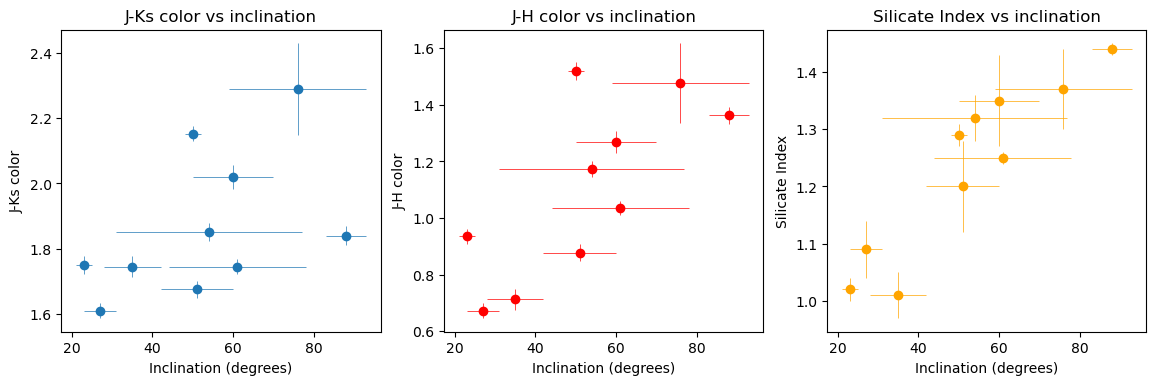

In [1113]:
# =========== plot a J-K color - inclination diagram ===========
plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(14,4))

inclination = suarez23['Inc']
incErr = suarez23['IncErr']
J, Ks = suarez23['J'], suarez23['Ks']
Jerr, Kserr = suarez23['Jerr'], suarez23['Kserr']
largerErr = []
for i in range(len(Jerr)):
    if Jerr[i] > Kserr[i]:
        largerErr.append(Jerr[i])
    else:
        largerErr.append(Kserr[i])
JKscolor = suarez23['J-Ks']

ax1.errorbar(x=inclination, y=JKscolor, xerr=incErr, yerr=largerErr, ls='', marker='o', lw=0.5)
ax1.set_xlabel('Inclination (degrees)')
ax1.set_ylabel('J-Ks color')
ax1.set_title('J-Ks color vs inclination')

# =========== plot a J-H color - inclination diagram ===========

J, H = suarez23['J'], suarez23['H']
Jerr, Herr = suarez23['Jerr'], suarez23['Herr']
largerErr = []
for i in range(len(Jerr)):
    if Jerr[i] > Herr[i]:
        largerErr.append(Jerr[i])
    else:
        largerErr.append(Herr[i])
JHcolor = suarez23['J-H']

ax2.errorbar(x=inclination, y=JHcolor, xerr=incErr, yerr=largerErr, c='r', ls='', marker='o', lw=0.5)
ax2.set_xlabel('Inclination (degrees)')
ax2.set_ylabel('J-H color')
ax2.set_title('J-H color vs inclination')

# =========== plot a silicate index - inclination diagram ===========
siIndex = suarez23.SilicateIndex
siErr = suarez23.Si_err
ax3.errorbar(x=inclination, y=siIndex, xerr=incErr, yerr=siErr, c='orange', ls='', marker='o', lw=0.5)
ax3.set_xlabel('Inclination (degrees)')
ax3.set_ylabel('Silicate Index')
ax3.set_title('Silicate Index vs inclination')